In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

In [3]:
from algos.nmcsTimed import *
from algos.nrpasTimed import *
from utils import *
from base import *

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
filename = "../data/c_memorable_moments.txt"

In [13]:
def get_score(ss_idx):
    ss = Slideshow()
    [ss.add_right(SLIDES[s]) for s in ss_idx]
    return sum(ss.scores)

@timeit
def mean_scores(n, sol, stabilized=False, monitor_time=False, delay=1000):
    scores = []
    for i in range(30):
        if stabilized:
            if monitor_time:
                ss = sol.run(n, verbose=0, stabilized=True, monitor_time=True, delay=delay)
            else:
                ss = sol.run(n, verbose=0, stabilized=True)
        else:
            if monitor_time:
                ss = sol.run(n, verbose=0, monitor_time=True, delay=delay)
            else:
                ss = sol.run(n, verbose=0)
        score = np.sum(ss.scores)
        scores.append(score)
    return np.mean(scores), scores

## NRPA
The first improvement over NMCS that we implemented is NRPA. We will see how it compares with NMCS for different compute times 

In [7]:
initial_time = 0.06
search_times = [initial_time]
for k in range(5):
    search_times.append(initial_time*2)
    initial_time = initial_time*2

In [19]:
NMCS_score = []
NRPA_score = []
for compute_time in search_times:
    # Run NMCS and get the score after compute_time
    sol = NestedMCSolutionTimed(filename, max_slides=50)
    a, b = mean_scores(2, sol, monitor_time=True, delay=compute_time)
    NMCS_score.append(a)
    
    # Run NRPA and get the score after compute_time
    sol = NRPASolutionTimed(filename, max_slides=50)
    sa, sb = mean_scores(2, sol, monitor_time=True, delay=compute_time)
    NRPA_score.append(sa)

df = pd.DataFrame(np.transpose(np.array([search_times, NMCS_score, NRPA_score])), columns=['searchTime','NMCS', 'NRPA'])
display(df)

orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 0.0017 sec
Num slides : 750
func:'mean_scores' took: 2.6909 sec
orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 0.0020 sec
Num slides : 750
func:'mean_scores' took: 1.8799 sec
orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 0.0011 sec
Num slides : 750
func:'mean_scores' took: 4.2249 sec
orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 0.0010 sec
Num slides : 750
func:'mean_scores' took: 3.6835 sec
orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 0.0019 sec
Num slides : 750
func:'mean_scores' took: 7.8051 sec
orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 0.0010 sec
Num slides : 750
func:'mean_scores' took: 7.2505 sec
orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 

,searchTime,NMCS,NRPA
0,0.06,0.466667,15.400000
1,0.12,2.266667,16.900000
2,0.24,5.000000,17.400000
3,0.48,10.333333,18.133333
4,0.96,22.800000,17.866667
5,1.92,23.900000,18.200000


We can see that using our best implementation of NRPA provides better results than our best implementation of NMCS for each compute time.

## Stabilized NRPA

Stabilized NRPA is a simple modification of the NRPA algorithm. It consists in periodically playing P playouts at the lowest level before performing the adaptation.

### Picking a good P value 
We set N=50 and level=2 in order to evaluate an appropriate P value. We iterate through 1 to 10.

In [ ]:
p_score = []
for p in range(1,10):
    sol = NRPASolution(filename, max_slides=50, N=50, P=p)
    a, b = mean_scores(2, sol, True)
    p_score.append(a)

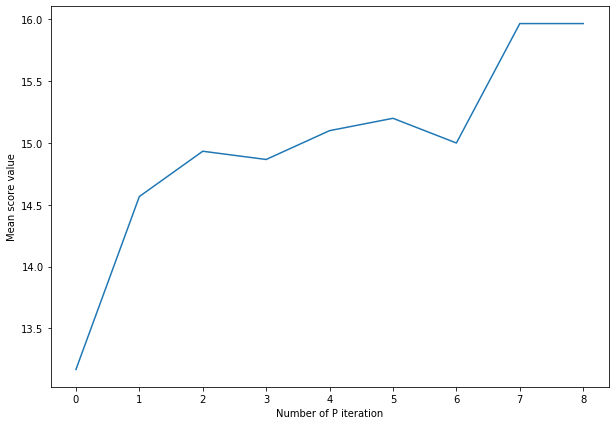

In [13]:
plt.figure(figsize=(10,7))
plt.plot(p_score)
plt.ylabel('Mean score value')
plt.xlabel('Number of P iteration')
plt.show()

Evaluation improves the performance for a growing P value. Thus, P=10 yields the best performance. 

### NRPA vs SNRPA(10)
Let's see with different compute time which algorithm yield the best performance

In [21]:
SNRPA_score = []
NRPA_score = []
for compute_time in search_times:
    # Run NRPA and get the score after compute_time
    sol = NRPASolutionTimed(filename, max_slides=50)
    sa, sb = mean_scores(2, sol, monitor_time=True, delay=compute_time)
    NRPA_score.append(sa)
    
    # Run SNRPA with P=10 and get the score after compute_time
    sol = NRPASolutionTimed(filename, max_slides=50)
    sa, sb = mean_scores(2, sol, True, monitor_time=True, delay=compute_time)
    SNRPA_score.append(sa)
    
df = pd.DataFrame(np.transpose(np.array([search_times,NRPA_score,SNRPA_score])), columns=['computeTime','NRPA_score', 'SNRPA_score'])
display(df)

orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 0.0017 sec
Num slides : 750
func:'mean_scores' took: 1.8816 sec
orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 0.0018 sec
Num slides : 750
func:'mean_scores' took: 1.9001 sec
orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 0.0023 sec
Num slides : 750
func:'mean_scores' took: 3.6912 sec
orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 0.0010 sec
Num slides : 750
func:'mean_scores' took: 3.6760 sec
orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 0.0010 sec
Num slides : 750
func:'mean_scores' took: 7.0031 sec
orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 0.0017 sec
Num slides : 750
func:'mean_scores' took: 7.0185 sec
orientation is V with type : <class 'str'>
1000 photos caught.
func:'form_slides' took: 

,computeTime,NRPA_score,SNRPA_score
0,0.06,15.566667,15.833333
1,0.12,16.766667,17.100000
2,0.24,17.600000,17.366667
3,0.48,17.433333,17.900000
4,0.96,17.566667,18.166667
5,1.92,17.933333,17.800000
